In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss
import sys

sys.path.append("../")

from src.common_functions import *


In [2]:
# sample data
# RAW_DATA_PATH = "../datasets/fraud/fin_fraud.csv"
# SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_1.csv"
SAMPLED_DATA_PATH ="C:/Users/stijn/OneDrive/Bureaublad/TEW 1ste jaar/python thesis/End-to-end-project---Customer-churn/datasets/fraud/cc_fraud_1.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data = pd.read_csv(RAW_DATA_PATH)
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.1, random_state=42, stratify=raw_data["fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH)
print(df.shape[0])
df.fraud.value_counts()/df.shape[0]*100

100000


fraud
0.0    91.26
1.0     8.74
Name: count, dtype: float64

In [3]:
df.isna().any()

Unnamed: 0                        False
distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

In [4]:
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,748493,40.751310,1.640059,0.563163,1.0,1.0,0.0,1.0,0.0
1,924852,1.282625,0.104560,0.349388,0.0,0.0,0.0,0.0,0.0
2,421808,20.369739,0.059844,0.327433,1.0,1.0,0.0,1.0,0.0
3,526416,10.537379,0.960467,0.232489,1.0,0.0,0.0,0.0,0.0
4,152659,8.519601,0.266422,3.804493,1.0,0.0,0.0,0.0,0.0


In [5]:
y = "fraud"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [6]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['fraud']),
                                        y = train['fraud']                                                    
                                    )
class_weights = dict(zip(np.unique(train['fraud']), class_weights))
class_weights

{0.0: 0.5478851632697787, 1.0: 5.720823798627002}

In [7]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'logistic__class_weight': [{0: 0.5478851632697787, 1: 5.720823798627002}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1, step_names_to_remove=['under', 'over'] )
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^

Best score: 0.9795465923789223
Best parameters: {'logistic__C': 1, 'logistic__class_weight': {0: 0.5478851632697787, 1: 5.720823798627002}, 'logistic__penalty': 'l2', 'pca__n_components': 8}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  [])])),
                ('pca', PCA(n_components=8)),
                ('logistic',
                 LogisticRegression(C=1,
                                    class_weight={0: 0.5478851632697787,
                                                  1: 5.720823798627002}))])

In [8]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [9]:
COLUMNS = ["pca__n_components", "logistic__class_weight", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS] #.sort_values(by=COLUMNS)

,pca__n_components,logistic__class_weight,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,6,"{0: 0.5478851632697787, 1: 5.720823798627002}",1,l2,0.924282,0.046455
1,8,"{0: 0.5478851632697787, 1: 5.720823798627002}",1,l2,0.979547,0.000841
4,6,"{0: 1, 1: 1}",1,l2,0.918606,0.045851
5,8,"{0: 1, 1: 1}",1,l2,0.967488,0.003715
8,6,"{0: 1, 1: 10}",1,l2,0.924280,0.046459
9,8,"{0: 1, 1: 10}",1,l2,0.979502,0.000864
12,6,"{0: 1, 1: 100}",1,l2,0.921938,0.046228
13,8,"{0: 1, 1: 100}",1,l2,0.978978,0.000585
16,6,"{0: 0.5478851632697787, 1: 5.720823798627002}",10,l2,0.924282,0.046456
17,8,"{0: 0.5478851632697787, 1: 5.720823798627002}",10,l2,0.979539,0.000847


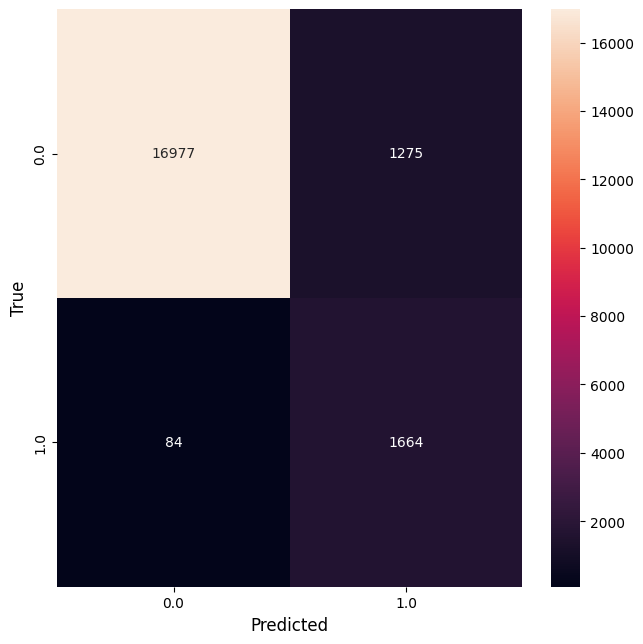

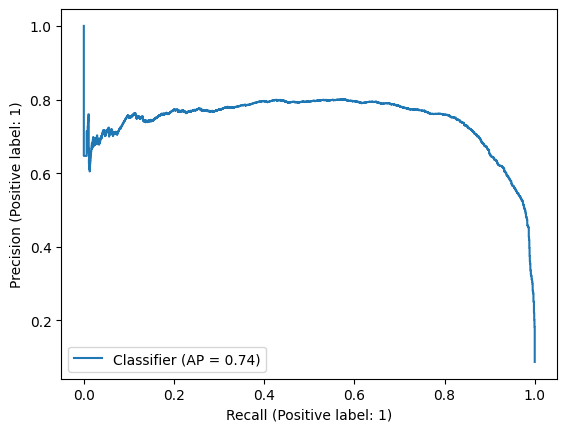

In [10]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name= 'logistic')

In [11]:
num_positive = np.sum(train == 1)
num_negative = np.sum(train == 0)
scale_pos_weight = num_negative / num_positive
print(scale_pos_weight)

Unnamed: 0                              NaN
distance_from_home                      NaN
distance_from_last_transaction          NaN
ratio_to_median_purchase_price          NaN
repeat_retailer                    0.134189
used_chip                          1.870779
used_pin_number                    8.976306
online_order                       0.534713
fraud                             10.441648
dtype: float64


In [12]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [8, 20, 25],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'xgb__scale_pos_weight':[1,5 ,10.441648, 20, 55 ,100,1000 ]
    
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True,  step_names_to_remove=['under', 'over'])
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9997557853109271
Best parameters: {'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 100, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'xgb__gamma': 2, 'xgb__colsample_bytree': 1.0, 'pca__n_components': 8}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(ste...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [13]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

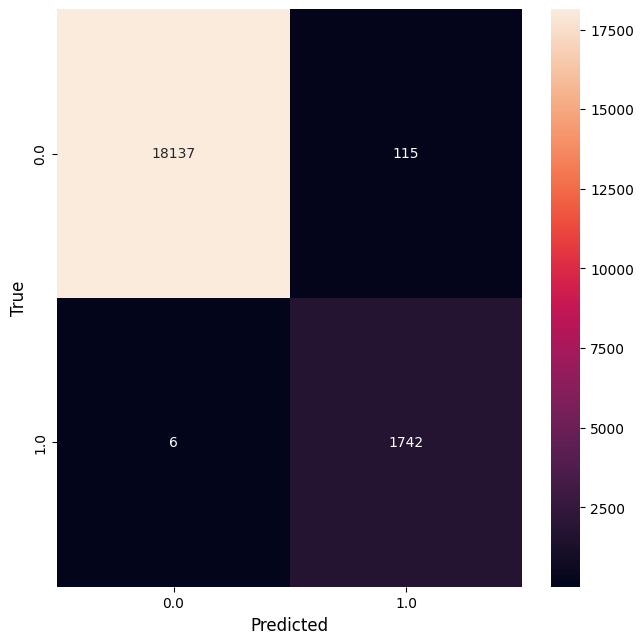

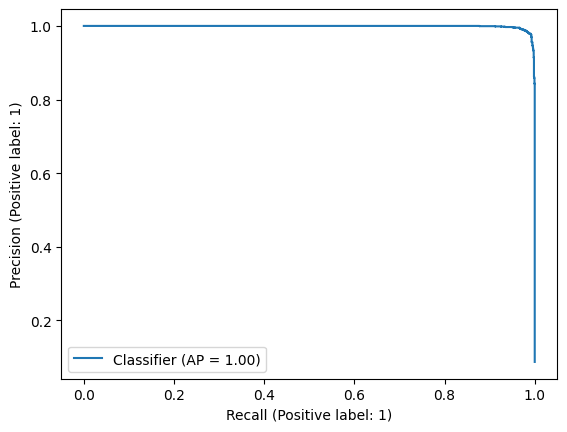

In [14]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [15]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [16]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 3329.
 total cost/loss average :  0.1664281834378244


In [17]:
print(test_predictions_log[['fraud', "A", 'instance_cost', 'y_predicted']].iloc[31:60])

       fraud              A  instance_cost  y_predicted
93892    0.0   10388.575914            0.0            0
20476    0.0   20414.840639            0.0            0
63548    0.0   14500.144617            0.0            0
99540    0.0   39799.740486            0.0            0
95543    0.0   43552.021289            0.0            0
23442    0.0    1737.407830            0.0            0
46527    0.0   34235.447023            0.0            0
10440    0.0    2822.560402            0.0            0
69763    0.0   20482.125038            0.0            0
38100    0.0   49965.529112            0.0            0
58622    0.0    6908.669945            0.0            0
34753    0.0   24230.205841            0.0            0
47355    0.0   46401.692821            0.0            0
77435    0.0    8750.969916            0.0            0
37768    0.0   13212.412937            0.0            0
47313    0.0    4876.795685            0.0            0
20416    0.0   11576.828326            0.0      

In [18]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 299.
 total cost/loss average :  0.014965444930488766


In [19]:
print(test_predictions_xgb[['fraud', "A", 'instance_cost', 'y_predicted']].iloc[150:180])

       fraud              A  instance_cost  y_predicted
91750    0.0   14725.285119            0.0            0
64367    0.0   22276.493375            0.0            0
48751    0.0  103176.312134            0.0            0
82817    0.0    8774.705591            0.0            0
45708    0.0   49619.184337            0.0            0
65195    0.0   16326.058735            0.0            0
21682    1.0   84920.824612            0.0            1
99183    0.0    8316.316780            0.0            0
59       0.0    5534.458173            0.0            0
89148    0.0    1339.907341            0.0            0
97895    0.0   15115.433639            0.0            0
29979    0.0   11085.245838            0.0            0
18693    0.0   21629.190410            0.0            0
62996    0.0  144244.013733            0.0            0
4927     0.0   18929.378659            0.0            0
15940    0.0   30900.912178            0.0            0
65106    0.0     643.533788            0.0      

# amc-metric

Decision Threshold: 0.01, Test cost/loss = 10793.00
Decision Threshold: 0.02, Test cost/loss = 9778.00
Decision Threshold: 0.03, Test cost/loss = 8691.00
Decision Threshold: 0.04, Test cost/loss = 7691.10
Decision Threshold: 0.05, Test cost/loss = 6925.10
Decision Threshold: 0.06, Test cost/loss = 6379.43
Decision Threshold: 0.07, Test cost/loss = 5952.80
Decision Threshold: 0.08, Test cost/loss = 5518.80
Decision Threshold: 0.09, Test cost/loss = 5254.65
Decision Threshold: 0.10, Test cost/loss = 4946.65
Decision Threshold: 0.11, Test cost/loss = 4762.14
Decision Threshold: 0.12, Test cost/loss = 4562.28
Decision Threshold: 0.13, Test cost/loss = 4404.74
Decision Threshold: 0.14, Test cost/loss = 4295.38
Decision Threshold: 0.15, Test cost/loss = 4160.30
Decision Threshold: 0.16, Test cost/loss = 4076.61
Decision Threshold: 0.17, Test cost/loss = 3990.78
Decision Threshold: 0.18, Test cost/loss = 3870.78
Decision Threshold: 0.19, Test cost/loss = 3785.09
Decision Threshold: 0.20, Test

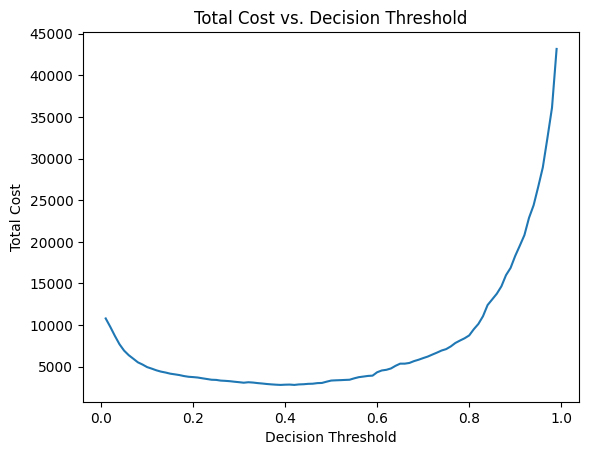

In [20]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 487.00
Decision Threshold: 0.02, Test cost/loss = 389.00
Decision Threshold: 0.03, Test cost/loss = 346.00
Decision Threshold: 0.04, Test cost/loss = 319.03
Decision Threshold: 0.05, Test cost/loss = 304.03
Decision Threshold: 0.06, Test cost/loss = 328.36
Decision Threshold: 0.07, Test cost/loss = 315.36
Decision Threshold: 0.08, Test cost/loss = 304.36
Decision Threshold: 0.09, Test cost/loss = 295.36
Decision Threshold: 0.10, Test cost/loss = 289.36
Decision Threshold: 0.11, Test cost/loss = 286.36
Decision Threshold: 0.12, Test cost/loss = 282.36
Decision Threshold: 0.13, Test cost/loss = 276.36
Decision Threshold: 0.14, Test cost/loss = 267.36
Decision Threshold: 0.15, Test cost/loss = 263.36
Decision Threshold: 0.16, Test cost/loss = 258.36
Decision Threshold: 0.17, Test cost/loss = 255.36
Decision Threshold: 0.18, Test cost/loss = 253.36
Decision Threshold: 0.19, Test cost/loss = 249.36
Decision Threshold: 0.20, Test cost/loss = 247.36


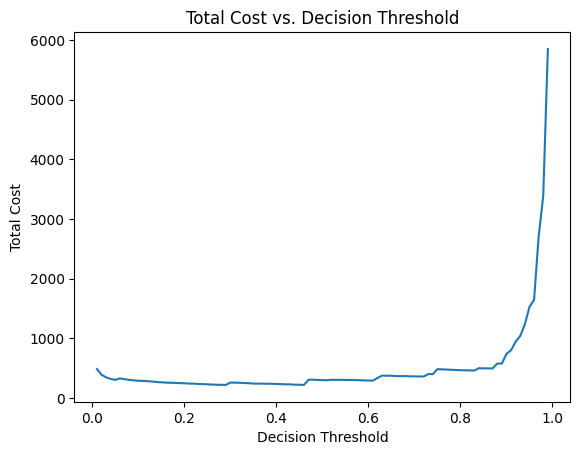

In [21]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud' )

# e-amc metric

In [22]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [23]:
test_predictions_log

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,...,5432.400509,0.000000,0.0,0.007800,0,2.716200,1,0,0.007800,0.087400
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,...,26294.025018,0.000000,0.0,0.180745,0,13.147013,1,0,0.180745,0.087400
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,...,29289.390585,0.000000,0.0,0.161635,0,14.644695,1,0,0.161635,0.087400
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,...,20321.210539,0.000000,0.0,0.000386,0,10.160605,1,0,0.000386,0.087400
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,...,8595.528192,0.000000,0.0,0.055772,0,4.297764,1,0,0.055772,0.087400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,1,...,94850.914540,47.425457,1.0,0.862651,0,47.425457,1,0,6.513857,43.280472
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,1,...,80424.956817,40.212478,1.0,0.734323,0,40.212478,1,0,10.683542,36.697908
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,1,...,286609.586793,0.000000,1.0,0.999999,0,143.304793,1,0,0.000140,130.779954
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,1,...,387418.501075,0.000000,1.0,1.000000,0,193.709251,1,0,0.000001,176.779062


In [24]:
test_predictions_xgb

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,...,5432.400509,0.000000,0.0,6.768347e-10,0,2.716200,1,0,6.768347e-10,0.087400
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,...,26294.025018,0.000000,0.0,3.357218e-08,0,13.147013,1,0,3.357218e-08,0.087400
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,...,29289.390585,0.000000,0.0,6.318647e-09,0,14.644695,1,0,6.318647e-09,0.087400
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,...,20321.210539,0.000000,0.0,1.719097e-08,0,10.160605,1,0,1.719097e-08,0.087400
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,...,8595.528192,0.000000,0.0,5.144142e-09,0,4.297764,1,0,5.144142e-09,0.087400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,1,...,94850.914540,0.000000,1.0,9.975857e-01,0,47.425457,1,0,1.145015e-01,43.280472
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,1,...,80424.956817,40.212478,1.0,8.951917e-01,0,40.212478,1,0,4.214600e+00,36.697908
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,1,...,286609.586793,0.000000,1.0,9.999683e-01,0,143.304793,1,0,4.544148e-03,130.779954
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,1,...,387418.501075,0.000000,1.0,9.999471e-01,0,193.709251,1,0,1.025282e-02,176.779062


In [25]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

7944.587028180056
92684.69795145269
EAP :  0.3972293514090028
EP :  4.634234897572634


In [26]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

551.9107317094418
92684.69795145269
EAP :  0.02759553658547209
EP :  4.634234897572634


# MP at 50% threshold

In [27]:
test_predictions_log_2= test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -1665.
 total cost/loss average :  -0.08322818343782439


In [28]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = 1443.
 total cost/loss average :  0.07213455506951123


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -9045.00
Decision Threshold: 0.02, Test cost/loss = -8030.00
Decision Threshold: 0.03, Test cost/loss = -6943.00
Decision Threshold: 0.04, Test cost/loss = -5944.10
Decision Threshold: 0.05, Test cost/loss = -5178.10
Decision Threshold: 0.06, Test cost/loss = -4633.43
Decision Threshold: 0.07, Test cost/loss = -4207.80
Decision Threshold: 0.08, Test cost/loss = -3773.80
Decision Threshold: 0.09, Test cost/loss = -3511.65
Decision Threshold: 0.10, Test cost/loss = -3203.65
Decision Threshold: 0.11, Test cost/loss = -3021.14
Decision Threshold: 0.12, Test cost/loss = -2822.28
Decision Threshold: 0.13, Test cost/loss = -2665.74
Decision Threshold: 0.14, Test cost/loss = -2558.38
Decision Threshold: 0.15, Test cost/loss = -2425.30
Decision Threshold: 0.16, Test cost/loss = -2343.61
Decision Threshold: 0.17, Test cost/loss = -2259.78
Decision Threshold: 0.18, Test cost/loss = -2139.78
Decision Threshold: 0.19, Test cost/loss = -2055.09
Decision Thr

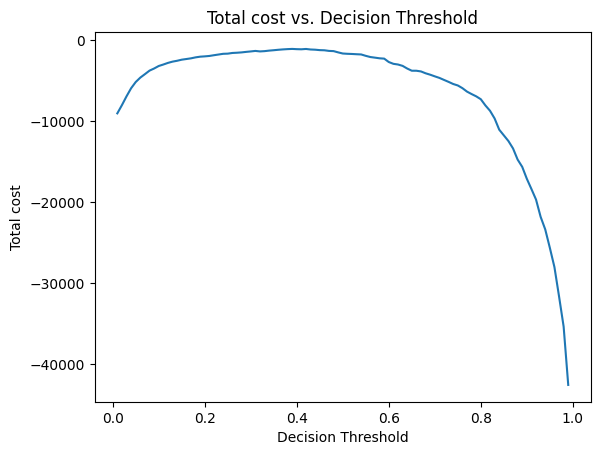

In [29]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2')


Decision Threshold: 0.01, Test cost/loss = 1261.00
Decision Threshold: 0.02, Test cost/loss = 1359.00
Decision Threshold: 0.03, Test cost/loss = 1402.00
Decision Threshold: 0.04, Test cost/loss = 1427.97
Decision Threshold: 0.05, Test cost/loss = 1442.97
Decision Threshold: 0.06, Test cost/loss = 1416.64
Decision Threshold: 0.07, Test cost/loss = 1429.64
Decision Threshold: 0.08, Test cost/loss = 1440.64
Decision Threshold: 0.09, Test cost/loss = 1449.64
Decision Threshold: 0.10, Test cost/loss = 1455.64
Decision Threshold: 0.11, Test cost/loss = 1458.64
Decision Threshold: 0.12, Test cost/loss = 1462.64
Decision Threshold: 0.13, Test cost/loss = 1468.64
Decision Threshold: 0.14, Test cost/loss = 1477.64
Decision Threshold: 0.15, Test cost/loss = 1481.64
Decision Threshold: 0.16, Test cost/loss = 1486.64
Decision Threshold: 0.17, Test cost/loss = 1489.64
Decision Threshold: 0.18, Test cost/loss = 1491.64
Decision Threshold: 0.19, Test cost/loss = 1495.64
Decision Threshold: 0.20, Test 

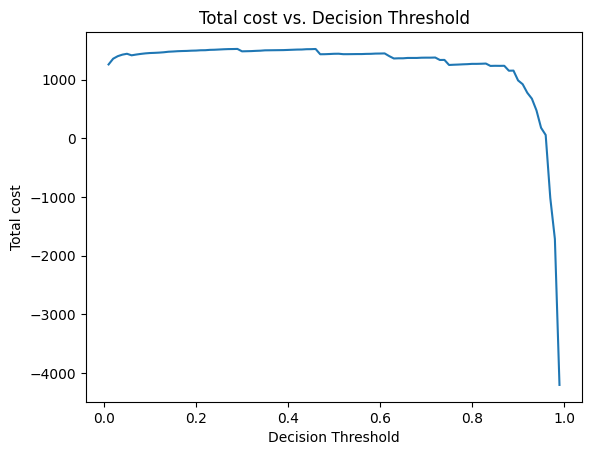

In [30]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud_2' )

# Emp

In [31]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [32]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-6384.866639736238
-92531.92275145269
EAP :  -0.3192433319868119
EP :  -4.626596137572634


In [33]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

1185.0895074430196
-92531.92275145269
EAP :  0.05925447537215098
EP :  -4.626596137572634


# cost curves

In [34]:
len(test_predictions_log['FP'])

20000

In [35]:
total_fp_log = 0

for i in range(0,20000):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/20000
print( average_fp_log)

1275
0.06375


In [36]:
total_fn_log = 0

for i in range(0,20000):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/20000
print( average_fn_log)

2053.563668756488
0.1026781834378244


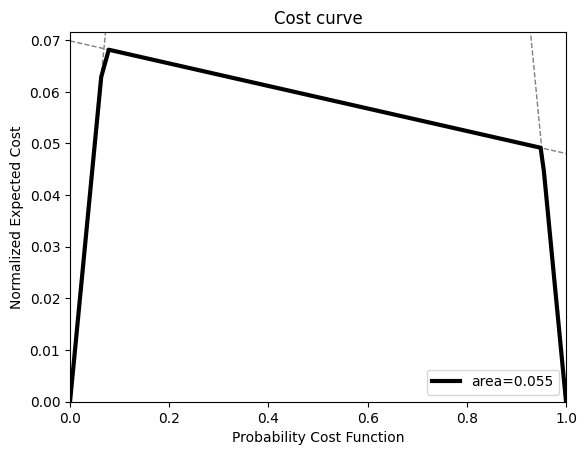

In [37]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [38]:
total_fp_xgb = 0

for i in range(0,20000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/20000
print( average_fp_xgb)

115
0.00575


In [39]:
total_fn_xgb = 0

for i in range(0,20000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/20000
print( average_fn_xgb)

184.30889860977533
0.009215444930488766


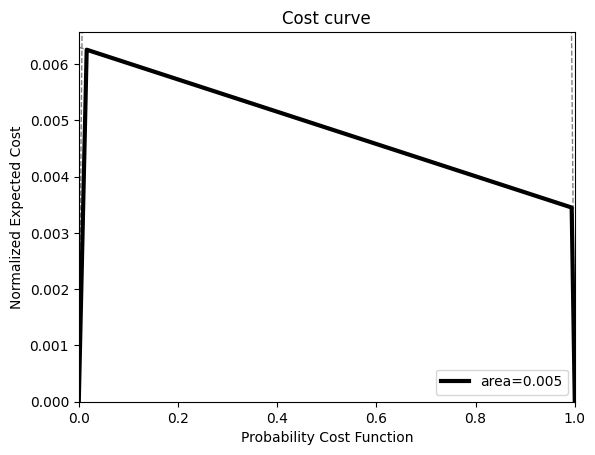

In [40]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the churn prediction cost and benefit matrices

# total cost at 50% decision threshold

In [41]:
test_predictions_log_churn = test.copy(deep=True)
test_predictions_log_churn["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn.drop(y, axis=1))
test_predictions_log_churn["churn_encoded"] = fit_le.transform(test_predictions_log_churn["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn['A'] = impute.fit_transform(
    (test_predictions_log_churn["ratio_to_median_purchase_price"]*10).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn['instance_cost'] = test_predictions_log_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn['instance_cost'].sum()/len(test_predictions_log_churn))

Test cost/loss = 133499.
 total cost/loss average :  6.674936592977075


In [42]:
test_predictions_xgb_churn = test.copy(deep=True)
test_predictions_xgb_churn["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn.drop(y, axis=1))
test_predictions_xgb_churn["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn['A'] = impute.fit_transform(
    (test_predictions_xgb_churn["ratio_to_median_purchase_price"]*10).to_frame())[:, 0]
    
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb_churn['A'] = scaler.fit_transform(test_predictions_xgb_churn['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn['instance_cost'] = test_predictions_xgb_churn.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_churn['instance_cost'].sum()/len(test_predictions_xgb_churn))

Test cost/loss = 14264.
 total cost/loss average :  0.7131868888576678


# amc metric

Decision Threshold: 0.01, Test cost/loss = 346739.98
Decision Threshold: 0.02, Test cost/loss = 325141.42
Decision Threshold: 0.03, Test cost/loss = 308438.28
Decision Threshold: 0.04, Test cost/loss = 292450.90
Decision Threshold: 0.05, Test cost/loss = 278846.94
Decision Threshold: 0.06, Test cost/loss = 267912.81
Decision Threshold: 0.07, Test cost/loss = 258766.57
Decision Threshold: 0.08, Test cost/loss = 249030.94
Decision Threshold: 0.09, Test cost/loss = 241912.35
Decision Threshold: 0.10, Test cost/loss = 234031.69
Decision Threshold: 0.11, Test cost/loss = 228469.50
Decision Threshold: 0.12, Test cost/loss = 222508.08
Decision Threshold: 0.13, Test cost/loss = 217572.48
Decision Threshold: 0.14, Test cost/loss = 213591.30
Decision Threshold: 0.15, Test cost/loss = 208935.76
Decision Threshold: 0.16, Test cost/loss = 204827.82
Decision Threshold: 0.17, Test cost/loss = 200860.02
Decision Threshold: 0.18, Test cost/loss = 197074.66
Decision Threshold: 0.19, Test cost/loss = 193

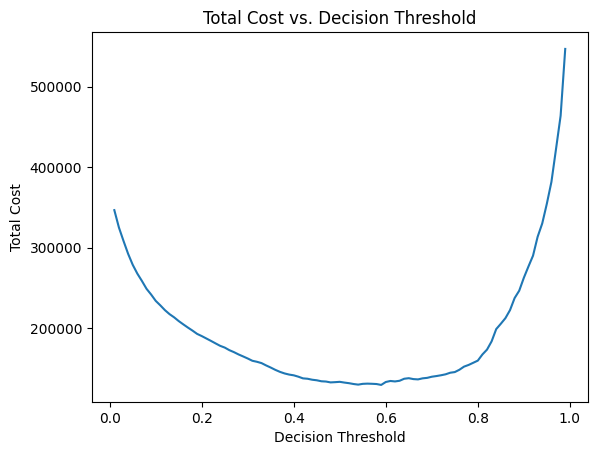

In [43]:
cb_column = 'A'
test_predictions_log_churn['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_churn, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn')

Decision Threshold: 0.01, Test cost/loss = 47715.36
Decision Threshold: 0.02, Test cost/loss = 37703.24
Decision Threshold: 0.03, Test cost/loss = 33797.84
Decision Threshold: 0.04, Test cost/loss = 30928.62
Decision Threshold: 0.05, Test cost/loss = 29327.12
Decision Threshold: 0.06, Test cost/loss = 27336.00
Decision Threshold: 0.07, Test cost/loss = 25900.76
Decision Threshold: 0.08, Test cost/loss = 24882.75
Decision Threshold: 0.09, Test cost/loss = 23975.06
Decision Threshold: 0.10, Test cost/loss = 23440.76
Decision Threshold: 0.11, Test cost/loss = 23219.48
Decision Threshold: 0.12, Test cost/loss = 22891.48
Decision Threshold: 0.13, Test cost/loss = 22586.88
Decision Threshold: 0.14, Test cost/loss = 21950.81
Decision Threshold: 0.15, Test cost/loss = 21744.49
Decision Threshold: 0.16, Test cost/loss = 21437.91
Decision Threshold: 0.17, Test cost/loss = 21309.03
Decision Threshold: 0.18, Test cost/loss = 21033.83
Decision Threshold: 0.19, Test cost/loss = 20649.87
Decision Thr

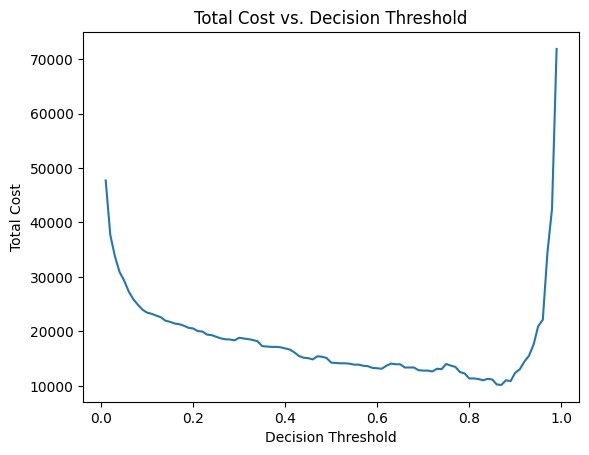

In [44]:
test_predictions_xgb_churn['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_churn, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn' )

# e- amc metric

In [45]:
test_predictions_log_churn = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="churn")
test_predictions_xgb_churn = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [46]:
print(test_predictions_log_churn['EAP'].sum())
print(test_predictions_log_churn['EP'].sum())


print('EAP : ', test_predictions_log_churn['EAP'].sum()/len(test_predictions_log_churn))
print('EP : ', test_predictions_log_churn['EP'].sum()/len(test_predictions_log_churn))

196796.6236599557
1138175.0720533356
EAP :  9.839831182997784
EP :  56.90875360266678


In [47]:
print(test_predictions_xgb_churn['EAP'].sum())
print(test_predictions_xgb_churn['EP'].sum())


print('EAP : ', test_predictions_xgb_churn['EAP'].sum()/len(test_predictions_xgb_churn))
print('EP : ', test_predictions_xgb_churn['EP'].sum()/len(test_predictions_xgb_churn))

19220.2964347855
1138175.0720533356
EAP :  0.9610148217392751
EP :  56.90875360266678


# mp at 50% threshold

In [48]:
test_predictions_log_churn_2 = test.copy(deep=True)
test_predictions_log_churn_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_churn_2.drop(y, axis=1))
test_predictions_log_churn_2["churn_encoded"] = fit_le.transform(test_predictions_log_churn_2["fraud"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_churn_2['A'] = impute.fit_transform(
    (test_predictions_log_churn_2["ratio_to_median_purchase_price"]*10).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_churn_2['instance_cost'] = test_predictions_log_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_churn_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_churn_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_churn_2['instance_cost'].sum()/len(test_predictions_log_churn_2))

Test cost/loss = 62020.
 total cost/loss average :  3.1010212140956335


In [49]:
test_predictions_xgb_churn_2 = test.copy(deep=True)
test_predictions_xgb_churn_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_churn_2.drop(y, axis=1))
test_predictions_xgb_churn_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_churn_2["fraud"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_churn_2['A'] = impute.fit_transform(
    (test_predictions_xgb_churn_2["ratio_to_median_purchase_price"]*10).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_churn_2['instance_cost'] = test_predictions_xgb_churn_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_churn_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_churn_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_churn_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_churn_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_churn_2['instance_cost'].sum()/len(test_predictions_xgb_churn_2))

Test cost/loss = 184994.
 total cost/loss average :  9.249696395229712


In [50]:
test_predictions_xgb_churn_2

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,0,2.716200,0.000000,0.0
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,0,13.147013,0.000000,0.0
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,0,14.644695,0.000000,0.0
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,0,10.160605,0.000000,0.0
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,0,4.297764,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,134541,92.077196,0.004849,5.896882,1.0,1.0,0.0,1.0,1.0,1,1,58.968817,117.937633,1.0
99422,200381,6.237010,1.860237,2.667288,1.0,1.0,0.0,1.0,0.0,0,0,26.672877,0.000000,0.0
40032,28631,24.032659,0.180503,0.495413,1.0,0.0,0.0,1.0,0.0,0,0,4.954133,0.000000,0.0
38101,974170,21.272029,1.104873,2.022286,1.0,1.0,0.0,0.0,0.0,0,0,20.222857,0.000000,0.0


# MP metric

Decision Threshold: 0.01, Test cost/loss = -147113.69
Decision Threshold: 0.02, Test cost/loss = -125515.13
Decision Threshold: 0.03, Test cost/loss = -108812.00
Decision Threshold: 0.04, Test cost/loss = -92828.81
Decision Threshold: 0.05, Test cost/loss = -79224.85
Decision Threshold: 0.06, Test cost/loss = -68371.39
Decision Threshold: 0.07, Test cost/loss = -59311.88
Decision Threshold: 0.08, Test cost/loss = -49576.25
Decision Threshold: 0.09, Test cost/loss = -42641.36
Decision Threshold: 0.10, Test cost/loss = -34760.70
Decision Threshold: 0.11, Test cost/loss = -29373.49
Decision Threshold: 0.12, Test cost/loss = -23496.37
Decision Threshold: 0.13, Test cost/loss = -18659.67
Decision Threshold: 0.14, Test cost/loss = -14853.78
Decision Threshold: 0.15, Test cost/loss = -10302.09
Decision Threshold: 0.16, Test cost/loss = -6398.76
Decision Threshold: 0.17, Test cost/loss = -2549.30
Decision Threshold: 0.18, Test cost/loss = 1236.06
Decision Threshold: 0.19, Test cost/loss = 5184

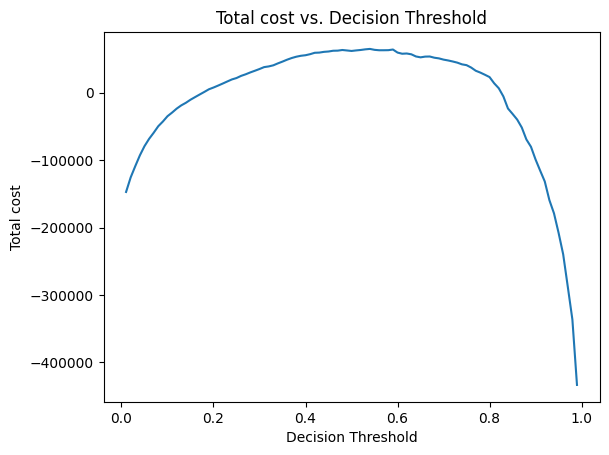

In [51]:
cb_column = 'A'
test_predictions_log_churn_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_churn_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_churn_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'churn_2')


Decision Threshold: 0.01, Test cost/loss = 151910.92
Decision Threshold: 0.02, Test cost/loss = 161923.04
Decision Threshold: 0.03, Test cost/loss = 165828.44
Decision Threshold: 0.04, Test cost/loss = 168683.60
Decision Threshold: 0.05, Test cost/loss = 170285.10
Decision Threshold: 0.06, Test cost/loss = 172179.57
Decision Threshold: 0.07, Test cost/loss = 173614.81
Decision Threshold: 0.08, Test cost/loss = 174632.82
Decision Threshold: 0.09, Test cost/loss = 175540.51
Decision Threshold: 0.10, Test cost/loss = 176074.81
Decision Threshold: 0.11, Test cost/loss = 176296.09
Decision Threshold: 0.12, Test cost/loss = 176624.09
Decision Threshold: 0.13, Test cost/loss = 176928.69
Decision Threshold: 0.14, Test cost/loss = 177564.76
Decision Threshold: 0.15, Test cost/loss = 177771.08
Decision Threshold: 0.16, Test cost/loss = 178077.66
Decision Threshold: 0.17, Test cost/loss = 178206.54
Decision Threshold: 0.18, Test cost/loss = 178481.74
Decision Threshold: 0.19, Test cost/loss = 178

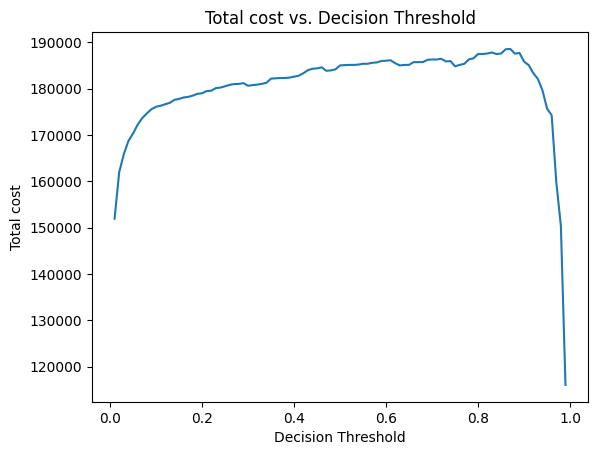

In [52]:
test_predictions_xgb_churn_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_churn_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_churn_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2' )

# E-MP metric

In [53]:
test_predictions_log_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_churn_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_churn_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [54]:
print(test_predictions_log_churn_2['EAP'].sum())
print(test_predictions_log_churn_2['EP'].sum())


print('EAP : ', test_predictions_log_churn_2['EAP'].sum()/len(test_predictions_log_churn_2))
print('EP : ', test_predictions_log_churn_2['EP'].sum()/len(test_predictions_log_churn_2))

-8985.676340743274
-1120727.734877274
EAP :  -0.4492838170371637
EP :  -56.036386743863694


In [55]:
print(test_predictions_xgb_churn_2['EAP'].sum())
print(test_predictions_xgb_churn_2['EP'].sum())


print('EAP : ', test_predictions_xgb_churn_2['EAP'].sum()/len(test_predictions_xgb_churn_2))
print('EP : ', test_predictions_xgb_churn_2['EP'].sum()/len(test_predictions_xgb_churn_2))

179571.61681022742
-1120727.734877274
EAP :  8.978580840511372
EP :  -56.036386743863694


# cost curves

In [56]:
total_fp_log_2 = 0

for i in range(0,20000):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 0 and test_predictions_log_churn['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_churn['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/20000
print( average_fp_log_2)

108855.9678344636
5.44279839172318


In [57]:
total_fn_log_2 = 0

for i in range(0,20000):
    if test_predictions_log_churn['churn_encoded'].iloc[i] == 1 and test_predictions_log_churn['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_churn['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/20000
print( average_fn_log_2)

24642.764025077846
1.2321382012538924


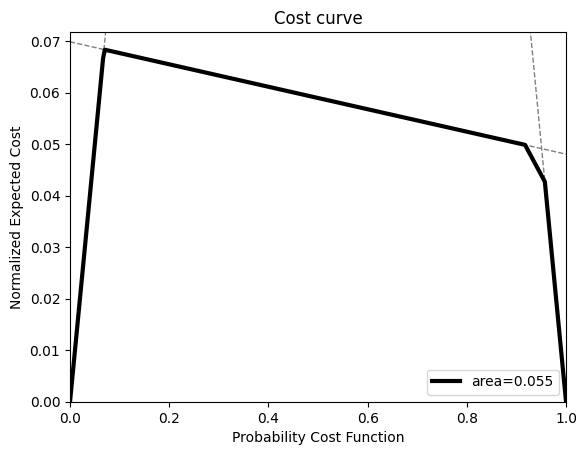

In [58]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [59]:
total_fp_xgb_2 = 0

for i in range(0,20000):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_churn['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_churn['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/20000
print( average_fp_xgb_2)

12052.030993836053
0.6026015496918027


In [60]:
total_fn_xgb_2 = 0

for i in range(0,20000):
    if test_predictions_xgb_churn['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_churn['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_churn['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/20000
print( average_fn_xgb_2)

2211.7067833173037
0.11058533916586519


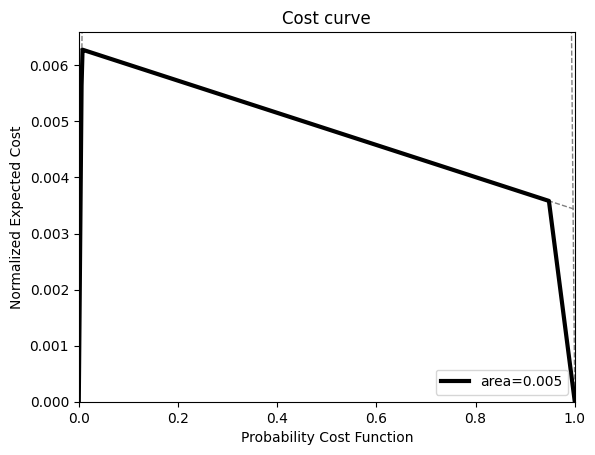

In [61]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_churn['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_churn['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()